In [22]:
import collections
import pickle
import functools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab

%matplotlib inline

In [35]:
with open('basic_buckets_with_avg_yards.pkl', 'rb') as f:
    buckets = pickle.load(f)
for i in range(len(buckets)):
    if buckets[i] == 6:
        buckets[i] = [6]
    buckets[i] = list(buckets[i])

In [36]:
buckets[:100]

[[6],
 [6],
 [6],
 [6],
 [6],
 [2, 1, 1],
 [3, 1, 1],
 [5, 1, 1],
 [6],
 [7, 2, 0, 5, 0],
 [6, 1, 4, 4, 0],
 [6, 2, 2, 4, 0],
 [6, 3, 0, 5, 0],
 [3, 1, 4, 5, 0],
 [3, 2, 4, 5, 0],
 [1, 1, 4, 5, 0],
 [1, 2, 4, 5, 0],
 [1, 3, 4, 5, 0],
 [2, 5, 0],
 [3, 5, 0],
 [5, 5, 0],
 [1, 1, 4, 4, 0],
 [1, 2, 4, 4, 0],
 [1, 2, 4, 3, 0],
 [0, 3, 2, 3, 0],
 [0, 4, 2, 3, 0],
 [0, 3, 0],
 [5, 3, 0],
 [6, 1, 4, 1, 1],
 [6, 2, 4, 1, 1],
 [6, 3, 3, 1, 1],
 [6, 4, 3, 1, 1],
 [8, 1, 4, 3, 0],
 [7, 2, 1, 4, 0],
 [5, 1, 4, 4, 0],
 [4, 2, 0, 5, 0],
 [3, 1, 4, 5, 0],
 [2, 2, 1, 5, 0],
 [1, 1, 4, 5, 0],
 [1, 2, 2, 4, 0],
 [1, 3, 3, 5, 0],
 [0, 1, 0, 4, 0],
 [2, 4, 0],
 [3, 4, 0],
 [5, 4, 0],
 [5, 1, 4, 1, 1],
 [5, 2, 3, 1, 1],
 [5, 3, 3, 1, 1],
 [5, 4, 3, 1, 1],
 [8, 1, 4, 4, 0],
 [7, 2, 1, 4, 0],
 [6, 1, 4, 4, 0],
 [6, 2, 3, 4, 0],
 [5, 1, 4, 4, 0],
 [6, 2, 6, 4, 0],
 [6, 3, 5, 4, 0],
 [4, 4, 1, 4, 0],
 [8, 1, 4, 1, 1],
 [7, 1, 4, 1, 1],
 [7, 2, 4, 1, 1],
 [6, 3, 1, 1, 1],
 [6, 4, 1, 1, 1],
 [7, 1, 4, 4, 0],
 [6,

In [37]:
counts = collections.defaultdict(collections.Counter)
for i in range(len(buckets) - 1):
    if buckets[i] != [6] and buckets[i+1] != [6]:
        start = buckets[i][:-1]
        end = buckets[i+1][:-2]
        if buckets[i][-1] == buckets[i+1][-1]:
            end.append(0)
        else:
            end.append(1)
    
        counts[tuple(start)][tuple(end)] += 1

In [38]:
counts.keys()

dict_keys([(6, 1, 6, 3), (1, 4, 0, 3), (3, 4, 6, 1), (3, 3, 1, 5), (7, 4, 3, 2), (6, 4, 7, 2), (0, 2, 2, 4), (8, 2, 6, 5), (0, 1, 4, 4), (5, 1, 4, 1), (1, 1, 0, 5), (9, 1, 4, 2), (2, 1, 2, 1), (4, 3, 1, 1), (0, 1, 0, 3), (4, 4, 0, 4), (7, 3, 1, 4), (9, 4, 0, 5), (5, 2, 6, 2), (0, 4, 1, 2), (2, 1, 6, 4), (4, 3, 5, 2), (2, 4, 2, 3), (4, 2, 1, 2), (7, 1, 6, 4), (7, 2, 2, 3), (3, 2), (0, 4, 1, 4), (7, 3, 5, 5), (4, 2, 5, 5), (6, 4, 2, 5), (0, 2, 1, 1), (3, 2, 2, 2), (7, 3, 0, 2), (2, 1, 6, 1), (6, 2, 5, 5), (8, 3, 1, 4), (8, 2, 5, 4), (4, 4, 3, 1), (6, 2, 4, 1), (5, 3, 4, 4), (4, 1), (3, 3, 0, 3), (7, 4, 0, 2), (5, 4, 6, 4), (0, 1, 4, 2), (2, 4, 1, 2), (5, 4, 2, 3), (9, 1, 7, 2), (4, 1, 5, 1), (8, 4, 0, 2), (0, 1, 1, 5), (6, 2, 1, 4), (6, 3, 7, 3), (9, 1, 3, 1), (3, 2, 7, 5), (4, 3, 6, 2), (4, 1, 0, 4), (9, 2, 7, 3), (5, 1), (8, 3, 6, 1), (6, 4, 1, 4), (9, 4, 5, 4), (5, 3, 7, 1), (7, 1, 0, 1), (9, 1, 4, 4), (4, 2, 4, 3), (6, 1, 0, 3), (2, 3, 3, 5), (8, 2, 4, 4), (3, 4, 4, 5), (7, 3, 3, 2),

In [40]:
counts[(6, 1, 6, 3)]

Counter({(2, 1, 4, 0): 2,
         (3, 1, 4, 0): 2,
         (4, 1, 4, 0): 7,
         (4, 2, 0, 0): 2,
         (4, 2, 4, 0): 1,
         (5, 1, 3, 0): 1,
         (5, 1, 4, 0): 1,
         (5, 2, 2, 0): 1,
         (5, 2, 3, 0): 2,
         (5, 2, 4, 0): 2,
         (5, 2, 5, 0): 12,
         (5, 2, 6, 0): 3,
         (6, 1, 5, 0): 1,
         (6, 2, 4, 0): 1,
         (6, 2, 5, 0): 10,
         (6, 2, 6, 0): 17,
         (7, 1, 7, 0): 3,
         (7, 2, 7, 0): 2})

In [44]:
def completely_in_counts(features, avg, pos_change):
    if pos_change == 1:
        for i in range(1,6):
            if tuple(list(features) + [i]) not in counts:
                return False
        return True
    return tuple(list(features) +[avg]) in counts

In [45]:
#remove states we can't support
counter = 0
updated = True
while updated:
    updated = False
    for bucket_start in counts:
        avg = bucket_start[-1]
        for bucket_end in counts[bucket_start]:
            end = list(bucket_end)[:-1]
            pos_change = bucket_end[-1]
            if counts[bucket_start][bucket_end] and not completely_in_counts(end, avg, pos_change):
                counts[bucket_start][bucket_end] = 0
                counter += 1
                updated = True
    
print(counter)

25


In [46]:
for bucket_start in counts:
    if sum(counts[bucket_start].values()) == 0:
        print('bad')

In [47]:
probabilities = collections.defaultdict(dict)
for bucket_start in counts:
    total = sum(counts[bucket_start].values())
    for bucket_end in counts[bucket_start]:
        if counts[bucket_start][bucket_end]:
            probabilities[bucket_start][bucket_end] = counts[bucket_start][bucket_end] / total

In [59]:
probabilities[(6,1,6,1)]

{(3, 1, 4, 0): 0.021052631578947368,
 (4, 1, 4, 1): 0.010526315789473684,
 (4, 2, 0, 0): 0.021052631578947368,
 (4, 2, 2, 0): 0.010526315789473684,
 (5, 1, 5, 0): 0.021052631578947368,
 (5, 2, 1, 0): 0.010526315789473684,
 (5, 2, 2, 0): 0.010526315789473684,
 (5, 2, 3, 0): 0.010526315789473684,
 (5, 2, 4, 0): 0.05263157894736842,
 (5, 2, 5, 0): 0.10526315789473684,
 (5, 2, 6, 0): 0.05263157894736842,
 (6, 1, 7, 0): 0.010526315789473684,
 (6, 2, 4, 0): 0.010526315789473684,
 (6, 2, 5, 0): 0.08421052631578947,
 (6, 2, 6, 0): 0.43157894736842106,
 (6, 2, 7, 0): 0.05263157894736842,
 (7, 1, 7, 0): 0.042105263157894736,
 (7, 2, 7, 0): 0.042105263157894736}

In [51]:
list(probabilities.keys())[0]

(6, 1, 6, 3)

In [60]:
rewards = collections.defaultdict(int)
rewards[(0,0)] = 3
rewards[(1,0)] = 2
rewards[(2,0)] = 6
rewards[(3,0)] = 1
rewards[(4,0)] = 2
for pair in list(rewards.keys()):
    rewards[(pair[0], 1-pair[1])] = -rewards[pair]
for a,b in list(rewards.keys()):
    for i in range(1,6):
        rewards[(a,i,b)] = rewards[(a,b)]
print(rewards)

defaultdict(<class 'int'>, {(0, 1, 1): -3, (2, 1, 1): -6, (4, 4, 1): -2, (2, 3, 0): 6, (1, 2, 1): -2, (3, 0): 1, (4, 4, 0): 2, (1, 3, 1): -2, (2, 1): -6, (3, 3, 1): -1, (1, 3, 0): 2, (3, 4, 1): -1, (0, 5, 0): 3, (3, 3, 0): 1, (0, 2, 1): -3, (2, 2, 0): 6, (4, 3, 0): 2, (0, 5, 1): -3, (4, 0): 2, (0, 2, 0): 3, (4, 3, 1): -2, (1, 4, 0): 2, (2, 4, 0): 6, (1, 4, 1): -2, (2, 3, 1): -6, (0, 3, 0): 3, (4, 5, 0): 2, (4, 5, 1): -2, (1, 2, 0): 2, (4, 1): -2, (1, 1): -2, (2, 2, 1): -6, (3, 2, 0): 1, (3, 5, 1): -1, (0, 0): 3, (3, 1, 1): -1, (3, 2, 1): -1, (2, 5, 0): 6, (3, 1, 0): 1, (4, 1, 0): 2, (0, 3, 1): -3, (1, 1, 1): -2, (3, 4, 0): 1, (2, 4, 1): -6, (1, 0): 2, (2, 5, 1): -6, (0, 1): -3, (1, 1, 0): 2, (2, 1, 0): 6, (3, 5, 0): 1, (0, 4, 1): -3, (3, 1): -1, (4, 2, 1): -2, (0, 4, 0): 3, (2, 0): 6, (4, 2, 0): 2, (1, 5, 1): -2, (0, 1, 0): 3, (1, 5, 0): 2, (4, 1, 1): -2})


In [76]:
THRESHOLD = 10**-8

@functools.lru_cache(maxsize = None)
def predicted_score_difference(current_state, num_turns_left, off_avg, def_avg):
    if num_turns_left == 0:
        answer = collections.defaultdict(float)
        answer[rewards[current_state]] = 1.0
        return answer
    
    child_score_diffs = collections.defaultdict(float)
    state, pos = current_state[:-1], current_state[-1]
    state = tuple(list(state) + [off_avg])
    #print(state, probabilities[state])
    for child_state in probabilities[state]:
        p = probabilities[state][child_state]
        
        child_state = list(child_state)
        pos_changed = child_state[-1]
        child_state[-1] = ((pos_changed + pos) % 2)

        child_state = tuple(child_state)
        
        if pos_changed:
            child_answer = predicted_score_difference(child_state, num_turns_left - 1, def_avg, off_avg)
        else:
            child_answer = predicted_score_difference(child_state, num_turns_left - 1, off_avg, def_avg)
            
        for score_diff in child_answer:
            child_score_diffs[score_diff] += p * child_answer[score_diff]
    
    answer = collections.defaultdict(float)
    for score_diff in child_score_diffs:
        if child_score_diffs[score_diff] > THRESHOLD:
            answer[score_diff + rewards[current_state]] = child_score_diffs[score_diff]
    return answer
    

defaultdict(<class 'float'>, {0: 0.06115875367835052, 1: 0.004438347798284723, 2: 0.0030062538099491502, 3: 0.08905470094708233, 4: 0.03186988693528131, 5: 0.002472656014289616, 6: 0.05188537120386707, 7: 0.15230646655876678, 8: 0.006508227573734347, 9: 0.0139894101026439, 10: 0.1659476702038596, 11: 0.0268607723371342, 12: 0.00470020903697891, 13: 0.04245936239170154, 14: 0.1548894175284226, 15: 0.006584082468678762, 16: 0.009453489916071414, 17: 0.060192677899907406, 18: 0.004659170061196934, 19: 0.0009897991934930653, 20: 0.008695961534298016, 21: 0.040144473799644344, 22: 0.002289395540000996, 23: 0.0008445433844369709, 24: 0.0018019906912303553, 25: 0.00012382675697935802, 26: 4.5697934764885606e-05, 27: 0.0004695398671672269, 28: 0.0010662340761882763, 29: 7.937108615901326e-05, 30: 9.806020446917006e-06, 31: 7.099048933224193e-06, 32: 5.498118685359432e-07, 33: 3.5621314386457643e-07, 34: 2.772665233842349e-06, 35: 3.874487558467053e-06, 36: 3.4473024985755605e-07, -2: 0.0008477

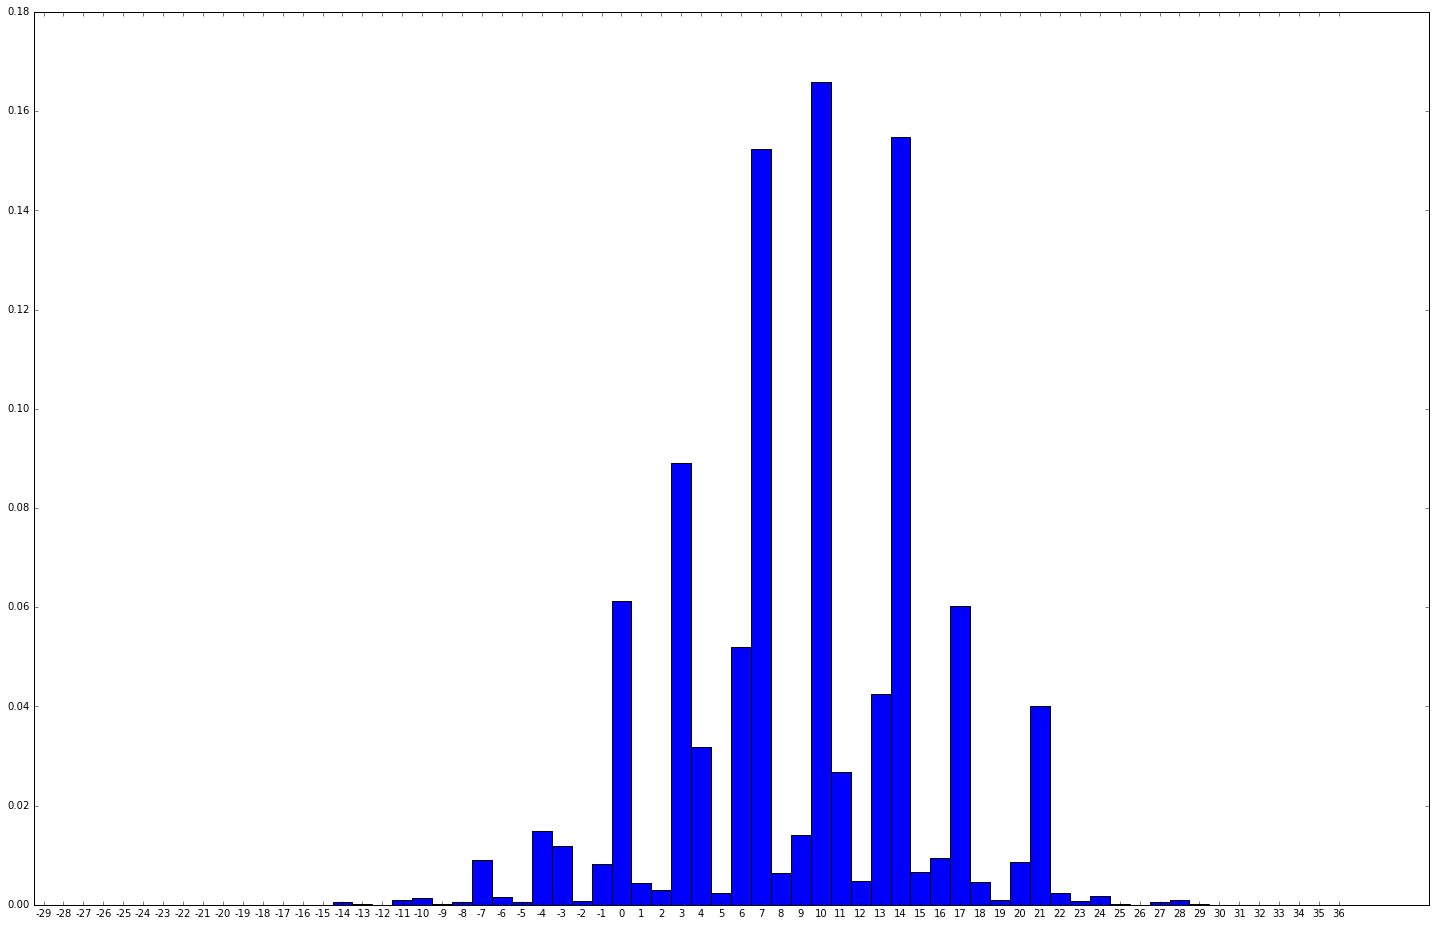

In [85]:
pdf = predicted_score_difference((4, 2, 2, 0), 40, 5, 1)
score_diff = []
probability = []
for s, p in sorted(pdf.items()):
    score_diff.append(s)
    probability.append(p)
pylab.rcParams['figure.figsize'] = (25.0, 16.0)
indexes = np.arange(len(score_diff))
width = 1

plt.bar(indexes, probability, width)
plt.xticks(indexes + width * 0.5, score_diff)
plt.show()

In [61]:
x = [1,2,3]
x.pop()

3

In [62]:
x

[1, 2]